# Quantifying the argument to abolish statutes of limitations for sex-related crimes
<hr>

<font size="3">Statutes of limitations are laws that cap the amount of time that can elapse after a crime has been committed before it can no longer be prosecuted. Such laws have been part of the American legal system since its founding, and their history dates back to Ancient Greek law. Not all states have statutes, but for those that do, depending on the crime, the window can be as short as 3 years. These laws exist to protect defendants from wrongful charges &ndash; the idea being that, over time, memories can become unreliable, physical evidence can be lost, and witnesses can be hard to find.
<br><br>
In the early 2000s, revelations of child-sexual-abuse by Catholic Church leaders made the public realize that many of the victims of these crimes didn't report their abuse for years or even decades, and since then many states have changed their laws for child sexual abuse crimes. In recent years, the #MeToo movement has focused attention on prosecution deadlines for rape and sexual assault, crimes that also often go unreported or are only reported years after they occurred.
<br><br>
Deciding whether or not to abolish statue of limitations for sex-related crimes is a complicated issue, and the purpose of this analysis is not to come to a conclusion on this matter. However, if we can find evidence that, on the whole, people wait significantly longer to report sex-related crimes than other crimes, it would be a strong argument in favor of abolishment. So, the objective of this analysis is to ask the question: <b> are reporting times for sex-related crimes significantly higher than those for non-sex-related crimes?</b>
</font>


## The data
<font size="3">To look at this, We're going to leverage 11 years (2008-2018) of Seattle crime records obtained from <a href=https://data.seattle.gov/Public-Safety/Crime-Data/4fs7-3vj5>Seattle's Open Data Program</a> (accessed on February 15, 2020). This dataset is useful for learning about crime-reporting behavior because it contains (i) the date a crime occurred, (ii) the date that it was reported, and (iii) what type of crime it was. An important caveat is that this dataset obviously provides no information about how frequently crimes go unreported for more than 11 years.
<br><br>
First, we'll import the data and do some quick cleaning &ndash; rename the columns and converting dates to datetime format.</font>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
import numpy as np
import pandas as pd

In [16]:
crimes = pd.read_csv("Crime_Data.csv", parse_dates=['Occurred Date','Reported Date'])
crimes.columns = ['id', 'date_occur', 'time_occur', 'date_reported', 'time_reported', 'subcategory', 'desc', 
                 'precinct', 'sector', 'beat', 'neighborhood']
crimes = crimes[(crimes.date_occur >= '2008-01-01') & (crimes.date_occur < '2019-01-01')]
crimes.head()

,id,date_occur,time_occur,date_reported,time_reported,subcategory,desc,precinct,sector,beat,neighborhood
1036,200800001981,2008-01-01,2330.0,2008-01-02,1819.0,CAR PROWL,THEFT-CARPROWL,SOUTHWEST,F,F3,SOUTH PARK
1037,200800001265,2008-01-01,2317.0,2008-01-01,2317.0,NARCOTIC,NARC-SELL-METH,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS
1038,200800001903,2008-01-01,2315.0,2008-01-02,1549.0,CAR PROWL,THEFT-AUTOACC,SOUTHWEST,F,F3,SOUTH PARK
1039,200800001226,2008-01-01,2300.0,2008-01-01,2316.0,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B2,FREMONT
1040,200800001201,2008-01-01,2252.0,2008-01-01,2252.0,DUI,DUI-LIQUOR,EAST,E,E2,CAPITOL HILL


<font size="3">There are about 500,000 crimes in the database. Here's the breakdown of Seattle crimes by category:</font>

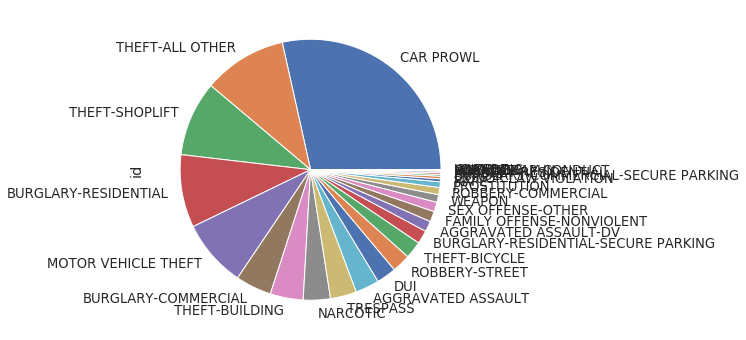

In [3]:
crimes.groupby('subcategory')['id'].count().sort_values(ascending=False).plot.pie(figsize=(6,6));

In [4]:
print(crimes.loc[crimes.subcategory.str.contains('ROBBERY|THEFT|BURGLARY|CAR PROWL',na=False)]['id'].count() / 
      crimes['id'].count())
print(crimes.loc[crimes.subcategory.str.contains('RAPE|SEXUAL OFFENSE|PORNOGRAPHY',na=False)]['id'].count() / 
      crimes['id'].count())

0.8143941261991324
0.004038040830175429


<font size="3">Not surprisingly, the bulk (81%) of crimes in Seattle are thefts of some type. Sex-related crimes &ndash; rape other sexual offenses &ndash; account for 0.4% of all crimes.
<br><br>
Okay, now let's look at reporting times. Below are histograms of reporting times on linear and log scales for all crimes. The vast majority of crimes get reported right away, but there is a long tail of reporting times that extends for around 11 years, which is the length of the dataset.</font>

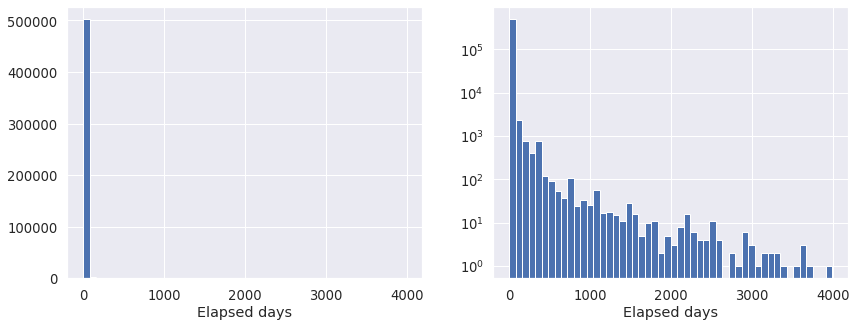

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.hist(((crimes.date_reported-crimes.date_occur)/np.timedelta64(1,'D')), 50)
ax2.hist(((crimes.date_reported-crimes.date_occur)/np.timedelta64(1,'D')), 50)
ax2.set_yscale('log')
ax1.set_xlabel('Elapsed days'); ax2.set_xlabel('Elapsed days');

## Dimension reduction via Principal Component Analysis
<font size="3">Although we could make similar plots for all of the crime categories, we're going to see what patterns naturally emerge from the dataset by using a technique called Principal Component Analysis (PCA).
<br><br>
Although we could try to look at the number of crimes reported as a function of days elapsed, as we saw above, there is a huge variation in the number of crimes in each category, which will tend to muddle our result. To make it clearer, we'll first transform the dataset, calculating the percent of crimes in each category that have been cumulatively been reported as a function of days elapsed.</font>

In [6]:
elapsed_days = pd.Series(np.arange(0, (crimes.date_reported-crimes.date_occur).max().days))
categories = crimes.groupby(crimes['subcategory'])['id'].count().sort_values(ascending=False)
X = pd.DataFrame(index=categories.index, columns=elapsed_days);

for category in categories.index:
    this_cat = crimes[crimes['subcategory'].str.contains(category, na=False)]
    this_cat_report_time = (this_cat.date_reported - this_cat.date_occur) / np.timedelta64(86400,'s') # convert to days
    for n_days in elapsed_days:
        # percent reported within certain time window
        X.at[category, n_days] = len(this_cat_report_time[this_cat_report_time < n_days]) / len(this_cat_report_time)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990
subcategory,,,,,,,,,,,,,,,,,,,,,
CAR PROWL,0,0.44711,0.809613,0.872477,0.906518,0.925038,0.936602,0.945215,0.952906,0.957388,...,1,1,1,1,1,1,1,1,1,1
THEFT-ALL OTHER,0,0.464033,0.647285,0.718266,0.764412,0.794808,0.81772,0.836308,0.851867,0.86278,...,1,1,1,1,1,1,1,1,1,1
THEFT-SHOPLIFT,0,0.869248,0.922711,0.939429,0.949464,0.957144,0.962639,0.966904,0.970213,0.972695,...,1,1,1,1,1,1,1,1,1,1
BURGLARY-RESIDENTIAL,0,0.586649,0.778751,0.832908,0.867413,0.888433,0.902859,0.914035,0.92617,0.932949,...,1,1,1,1,1,1,1,1,1,1
MOTOR VEHICLE THEFT,0,0.374193,0.828512,0.889695,0.920134,0.936955,0.946874,0.954036,0.960467,0.96426,...,1,1,1,1,1,1,1,1,1,1


<font size="3">Additionally, in the step above we organized the data with a pivot table to matrix where each row corresponds to a crime category and each column corresponds to the number of days ellapsed. We now have a dataset with a few thousand dimensions. This uses the entire dataset, but it is admittedly a bit extreme, and the analysis would work just as well if we limited it to, say, crimes reported within a year of when they occurred.
<br><br>
Now we'll try to reduce the dimensions of our matrix with PCA, asking for the components that explain at least 95% of the variance of the data:</font>

In [7]:
from sklearn.decomposition import PCA
Xpca = PCA(0.95).fit_transform(X)
Xpca.shape

(30, 2)

<font size="3">This appears to have worked well &ndash; the result has only two dimensions, which we can eaily plot:</font>

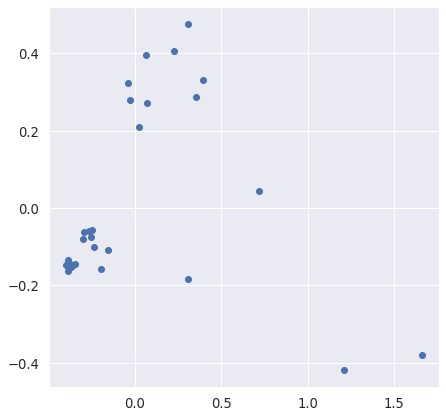

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(Xpca[:,0], Xpca[:,1],'o');

## Unsupervised Clustering
<font size="3">The plot above shows that the data fall into several groups &ndash; some tightly clustered and some are more dispersed. Because the clusters have very different sizes, a basic k-Means approach will struggle to group them appropriately. We'll use the <b>Spectral Clustering</b> algorithm from the scikit-learn package and assume 4 clusters.</font>

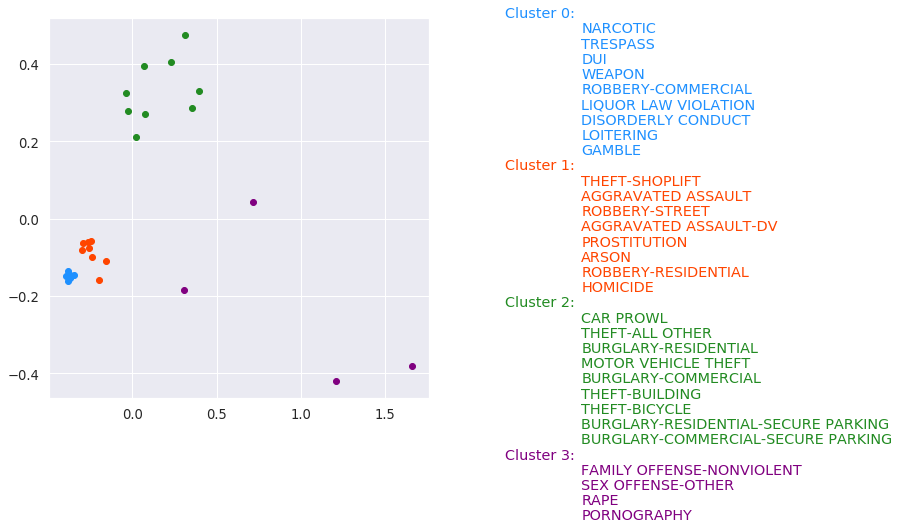

In [9]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans', random_state=0)
labels = model.fit_predict(Xpca)

# change label order for consistent plotting
mean_dist = []
for i in range(0,4):
    ind = labels==i
    mean_dist.append(np.sqrt(np.power(Xpca[ind,0]-Xpca[ind,0].mean(),2) + np.power(Xpca[ind,1]-Xpca[ind,1].mean(),2)).mean())
order = np.argsort(mean_dist)
new_labels = np.nan * np.ones(labels.shape)
for i in range(0,4):
    new_labels[labels==i] = order[i]
new_labels = new_labels.astype(int)

# now plot
y_text = 1
colors = ['dodgerblue', 'orangered', 'forestgreen', 'purple']
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
for i in range(0,4):
    ind = new_labels==i
    ax1.plot(Xpca[ind, 0], Xpca[ind, 1], 'o', color=colors[i]);
    ax2.text(0,y_text, "Cluster " + str(i) + ":", color=colors[i])
    y_text=y_text-0.04
    for j in range(0, len(categories.iloc[new_labels==i])):
        ax2.text(.2,y_text, categories.index[new_labels==i][j], color=colors[i])
        y_text=y_text-0.04
ax2.axis('off');

<font size="3">The algorithm has identified the natural clusters. Let's take a closer look a the contents of each cluster:
<br><br>
    <b><font color="#3e82fc">Cluster 0:</font></b> Crimes where the criminal is typically caught committing the crime by the police. There is often zero or very little elapsed time between when the occurrence and the reporting of a crime.
<br><br>
    <b><font color="fd411e">Cluster 1:</font></b> Crimes that are typically reported to the police after they occur, causing more elapsed time between occurrence and reporting compared to Cluster 0.
<br><br>
    <b><font color="089404">Cluster 2:</font></b> All thefts or burlaries. As with Cluter 1, most of these are reported to the police subsequent to their occurrence, resulting in elapsed time. 
    <br><br>
    <b><font color="7e1e9c">Cluster 3:</font></b> All sex- or family-related crimes. No material theft occurs in these crimes, and we expect the greatest time to elapse, on average, between the occurrence and the reporting of a crime. 
<br><br>
    Interestingly, scatter increases from Cluster 0 to Cluster 3, which presumably reflects increasing variance in reporting time.
<br><br>
Let's annotate this plot to highlight some features. We'll circle all of the crime categories whose name contains the text "ROBBERY", "THEFT", "BURGLARY", or "CAR PROWL". We'll also label the crimes in Cluster 3.
</font>
    

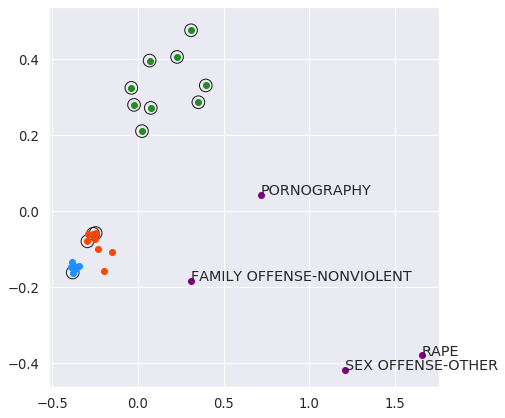

In [10]:
fig, ax1 = plt.subplots(1,1, figsize=(7,7))
for i in range(0,4):
    ind = new_labels==i
    ax1.plot(Xpca[ind, 0], Xpca[ind, 1], 'o', color=colors[i]);
    
ind = np.where(categories.index.str.contains('ROBBERY|THEFT|BURGLARY|CAR PROWL',na=False))
ax1.scatter(Xpca[ind, 0], Xpca[ind, 1], s=160, facecolors='none', edgecolors='k');

ind = np.where(categories.index.str.contains('FAMILY|SEX|RAPE|PORN',na=False))
ind = ind[0]
len(ind)
for i in range(0,len(ind)):
    ax1.text(Xpca[ind[i], 0], Xpca[ind[i], 1], categories.index[ind[i]])


<font size="3">My <i>a priori</i> expectation was that the categories SEX OFFENSE-OTHER and RAPE would cluster together, which they do. Interestingly, the PCA revealed that PORNOGRAPHY and FAMILY OFFENSE-NONVIOENT are most similar to these crimes. In hindsight this seems intuitive, but I didn't anticipate it.</font>

## Crime reporting behavior

<font size="3">Okay, now let's plot <b>cumulative distribution functions</b> for each cluster and for each cluster member. These curves represent the cumulative fraction of crimes reported as a function of the amount of time elapsed.
</font>

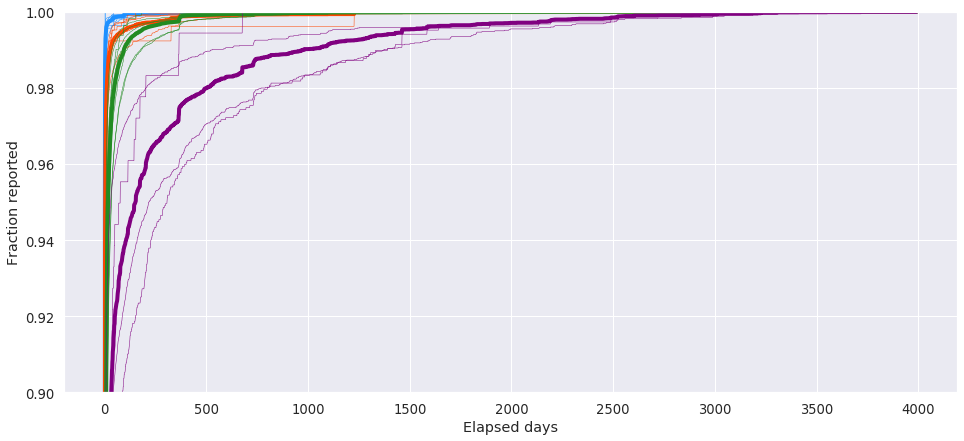

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
for i in range(0,4):
    ax.plot(X.iloc[new_labels==i].mean(axis=0), color=colors[i], lw=4)
    for j in range(0, len(X.iloc[new_labels==i])):
        ax.plot(X.iloc[new_labels==i].iloc[j], color=colors[i], lw=0.5)
ax.set_ylabel('Fraction reported'); plt.xlabel('Elapsed days')
ax.set_ylim([9e-1, 1]);

<font size="3">We see that most crimes are reported right away regardless of category. However, the average elapsed time <i>increases</i> from <font color="#3e82fc">Cluster 0</font> to <font color="fd411e">Cluster 1</font> to <font color="089404">Cluster 2</font> to <font color="7e1e9c">Cluster 3</font>. 
    <br><br>
    The difference between <font color="7e1e9c">Cluster 3</font> and the other clusters appears quite large, but let's do a significance test to be sure. We'll borrow a technique from the branch of statistics known as <b>survival analysis</b>, which looks at the duration of time until events happen. We'll use the log-rank method to test the null hypothesis that the CDF for <font color="7e1e9c">Cluster 3</font> is no different from the CDF of the other 3 clusters combined.
</font>

In [12]:
from lifelines.statistics import logrank_test

subset = crimes[crimes['subcategory'].isin(categories[new_labels==3].index)]    
T1 = (subset.date_reported-subset.date_occur)/np.timedelta64(1,'D')
E1 = np.ones(len(T1))

subset = crimes[crimes['subcategory'].isin(categories[new_labels!=3].index)]    
T2 = (subset.date_reported-subset.date_occur)/np.timedelta64(1,'D')
E2 = np.ones(len(T2))

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
results.print_summary()

<font size="3">The log-rank test results in a <i>p</i>-value <0.005, indicating that, as expected, the difference between <font color="7e1e9c">Cluster 3</font> and the other clusters combined is statistically significant.
<br><br>
The CDFs above show the percent of crimes reported as a function of elapsed time. Let's distill some of that information in a table:
</font>

In [13]:
n_days = 7
for i in range(0,4):
    print(np.interp(n_days, X.columns.values, X.iloc[new_labels==i].mean(axis=0)*100))

99.55495710763009
97.4296637064674
89.7238517005284
81.04316268393451


<font size="3">
    <table>
        <tr><th></th><th>1 week</th><th>1 month</th><th>1 year</th><th>4 years</th></tr>
    <tr><th><font color="#3e82fc">Cluster 0</font></th><td>99.6</td><td>99.8</td><td>100</td><td>100</td></tr>
    <tr><th><font color="fd411e">Cluster 1</font></th><td>97.4</td><td>99.0</td><td>99.8</td><td>100</td></tr>
    <tr><th><font color="089404">Cluster 2</font></th><td>89.7</td><td>96.9</td><td>99.8</td><td>100</td></tr>
    <tr><th><font color="7e1e9c">Cluster 3</font></th><td>81.0</td><td>89.4</td><td>97.3</td><td>99.4</td></tr>
    </table>
</font>

## Summary

<font size="3"> 
We have shown that 11 years of basic crime records for Seattle contain powerful information about the reporting behavior associated with different types of crimes. The take-home point is that, as a whole, sex-related crimes are, in fact, reported after more time has elapsed than other crimes, and that this difference is statistically significant.
<br><br>
As discussed in the beginning of this article, the question of whether or not abolish a statute of limitations is complicated, and the interests of victims must be weighed against the risk of wrongful accusations. However, the finding that people commonly report sex-related crimes long after they occur (and long after other crimes are reported) is evidence in support of abolishing statutes of limitations for sex-related crimes.</font>